Group Name: AG 3.

Student Name (Student ID):

1. JEREMY LIAN ZHI WEI (A0250972B)

2. LAU ZHE RU ZACHARY (A0256006M)

3. ONG EE WEN, LENNARD (A0034832L)

# Question 1

Consider the maze shown below. The Maze has 16 rows and 24 columns The objective is to find a shortest path from cell $S$ to cell $G$.


![Maze](Maze_Assignment_1.jpg)


The agent can take four actions in each cell: 'RIGHT', 'DOWN', 'UP', 'LEFT'.  

Each cell is represented as $(x,y)$, where $x$ indicates row number and $y$ indicates column number. Action 'UP' takes the agent from cell $(x,y)$ to $(x+1,y)$. Action 'DOWN' takes the agent from cell $(x,y)$ to $(x-1,y)$. Action 'RIGHT' takes the agent from cell $(x,y)$ to $(x,y+1)$. Action 'LEFT' takes the agent from cell $(x,y)$ to $(x,y-1)$. The triplet $(s,a,s')$  indicates that taking action $a$ at state $s$ leads to state $s'$. Actions 'LEFT' or 'RIGHT' cost 10 units for all $(s,a,s')$. Actions 'UP' or 'DOWN' cost 1 unit for all  $(s,a,s')$.  The agent cannot move into cells that are shaded. Assume that the agent knows the boundaries of the maze and has full observability. Consequently, at the bottom (row 0) and top (row 15), the agent will not take actions 'DOWN' and 'UP', respectively; at left (column 0) and right (column 23) columns, the agent will not take 'LEFT' and 'RIGHT' actions, respectively. Similalry, the agent will not take actions that lead to shaded region in the maze.

## **Q1.a: Class Maze(Problem)** [3 Marks]

Write a Maze class to create a model for this problem. You should not use an explicit state space model. The modelling should inherit the abstract class 'Problem' (given below). With the problem formulation, find the shortest path from S to G cell. Propose and implement multiple heuristics (at least two heuristics) for informed search algorithms. 

## **Q1.b: Analysis of the Algorithms** [7 Marks]

1. Solve the above Maze problem using the following algorithms

    a. Breadth-First Search

    b. Depth-First Search with Cycle-Check

    c. Iterative-Deepening Search with Cycle-Check

    d. Uniform-Cost Search

    e. A* Search 

    f. Greedy Best-first Search

    g. Any other variants for search algorithms that are not discussed in the class (bonus/optional question) 

2. Identify the number of nodes generated, number of nodes expanded, maximum frontier size, and path-cost for the above algorithms. 
 
3. Compare the performance of informed search algorithms with proposed heuristics. Identify the best performing heuristic and explain.
 
4. Draw a bar plot comparing the statistics of the algorithms and explain the results. 

Note 1: You must follow the problem formulation discussed in the class. A abstract class for Problem amd Node definition is presented below. The search tree generation should follow the template discussed in the class (i.e., Node class, expand methods, etc.). 

Note 2: If you are borrowing a block of code (for example, helper functions or data structures, etc.) from AIMA4e repository, you have to acknowledge it in the code. 

Note 3: The code should be written in a single jupyter notebook file.

In [1]:
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

In [2]:
# Use the following Node class to generate search tree
import math
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost

## Formalising the Maze problem statement

Let us first formulate the Maze into a Problem class.

In [3]:
class Maze(Problem):
    """
    The class for a maze problem. Inherits class Problem.
    """
    def __init__(self, initial, goal, rows, cols, cost, obs):
        super().__init__(initial, goal, xlimit=rows, ylimit=cols, cost=cost, obstacles=obs)
    
    def actions(self, state):
        """
        The actions at a cell are just its neighbours, while respecting maze boundaries and obstacles.
        """
        action_list = []
        moves = {
                    'left': (state[0], state[1]-1),\
                    'right': (state[0], state[1]+1),\
                    'up': (state[0]+1, state[1]),\
                    'down': (state[0]-1, state[1])\
                }
        for direction, end_state in moves.items():
            # Check for validity of actions (map boundaries and wall obstacles)
            if (0 <= end_state[0] < self.xlimit) and (0 <= end_state[1] < self.ylimit)\
                                                    and (end_state not in self.obstacles):
                action_list.append(direction)
        return action_list

    def result(self, state, action):
        """
        The result of going to a neighbouring cell is the state of that cell.
        """
        moves = {
                    'left': (state[0], state[1]-1),\
                    'right': (state[0], state[1]+1),\
                    'up': (state[0]+1, state[1]),\
                    'down': (state[0]-1, state[1])\
                }
        return moves[action] 

    def action_cost(self, s, a, s1):
        """
        The cost of taking an action from cell s to cell s1 is the cost of move 'a'.
        """
        return self.cost[a]
    
    def h(self, node):
        """
        Default heuristic func - straight-line distance between node and goal.
        """
        s = node.state
        return sum(abs(a - b)**2 for (a, b) in zip(s, self.goal)) ** 0.5

## Special Node class objects

In addition to solution node objects, we need other types of returned objects in the event that:
* FAILURE --- No solutions are found (search algorithmn is incomplete)
* CUTOFF --- Search process was terminated (search algorithmn termination condition met)

In [4]:
# Defining special return values -- Courtesy of AIMA 4e Python Repo
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.

## Data Structures

We now define some data structures needed for the various search algorithmn implementations.

In [5]:
# Defining data structures for use in the algos
class linked_lst():
    def __init__(self,data):
        self.data = data
        self.next = None
        
class FIFOQueue():
    def __init__(self, node=[]):
        self.front = None
        self.rear = None
        self.size = 0
        self.max = 0
        for n in node:
            self.append(n)
            
    def append(self,data):
        temp = linked_lst(data)
        if self.front == None:
            self.front = temp
            self.rear = temp
            self.size += 1
            self.max_size()
        else:
            curr = self.rear
            curr.next = temp
            self.rear = temp
            self.size += 1
            self.max_size()
            
    def pop(self):
        if self.size == 0:
            raise Exception("FIFOQueue is Empty")
        else:
            temp = self.front
            self.front = self.front.next
            self.size -= 1
            return temp.data
            del temp
            
    def max_size(self):
        if self.size > self.max:
            self.max = self.size
            
    def __len__(self):
        return self.size
    
    def __bool__(self):
        return self.size > 0
    
    def __max__(self):
        return self.max
            
class LIFOQueue(list):
    def __init__(self, arr):
        super().__init__(arr)
        self.max = 0
        self.size = 0
        
    def append(self, x):
        super().append(x)
        self.size = self.__len__()
        self.max_size()
        
    def max_size(self):
        if self.size > self.max:
            self.max = self.size
    
    def __max__(self):
        return self.max
    
class PriorityQueue():
    """A queue in which item x with minimum f(x) is popped first."""
    def __init__(self, items=(), f=lambda x: x):
        self.items = []
        self.values = []
        self.f = f
        self.size = 0
        self.max = 0
        for item in items:
            self.append(item)

    def append(self, item):
        self.items.append(item)
        fvalue = self.f(item)
        self.values.append(fvalue)
        self.size = self.__len__()
        self.max_size()

    def pop(self):
        """Pop and return the item with min f(item) value."""
        if self.items:
            index = 0
            fvalue = self.values[0]
            for i, _ in enumerate(self.items):
                if self.values[i] < fvalue:
                    fvalue = self.values[i]
                    index = i
            self.values.pop(index)
            return self.items.pop(index)

    def __len__(self):
        return len(self.items)
    
    def max_size(self):
        if self.size > self.max:
            self.max = self.size
    
    def __max__(self):
        return self.max

## Helper functions for search algorithmns and solution path/action trace

Let us define some functions we will be needing for running the search algorithmns and solution tracing later.

In [6]:
# Some helper funcs for running the various search algos later -- Courtesy of AIMA 4e Python Repo
def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)

def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

## Initialising problem variables

Here, we are defining our 
* start state
* goal state
* boundaries of our maze
* cost of each action type
* obstacles in the maze

In [7]:
# Initialising variables
start = (8, 10) # Starting cell
goal = (11, 9) # Goal cell
width = 24 # No. of columns in maze...
height = 16 # No. of rows in maze...
cost = {'left': 10, 'right': 10, 'up': 1, 'down': 1}
walls = [(6, 9), (7, 9), (8, 9), (9, 9), (10, 9), (10, 10), (11, 10), (12, 10), (13, 10), (14, 9), \
             (10, 12), (11, 12), (10, 13), (11, 13)]


maze = Maze(start, goal, rows=height, cols=width, cost=cost, obs=walls)

### Searching high and low...

Finally, we can begin formulating our various search strategies.

# Uninformed Search Strategies

## Breadth First Tree Search

In [8]:
# BFS (tree) -- Courtesy of AIMA 4e Python Repo
def breadth_first_search(problem):
    """
    Searches shallowest nodes in the search tree first.
    Repeats infinitely in case of loops.
    
    Courtesy of AIMA 4e Python Repo
    """
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node, frontier.__max__()
    frontier = FIFOQueue([node])
    while frontier:
        node = frontier.pop()       
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child, frontier.__max__()
            frontier.append(child)
    return failure, frontier.__max__()

## Depth First Tree Search (with cycle-check)

In [9]:
# DFS (tree with cycle-check)
def depth_first_tree_search(problem):
    """
    Searches the deepest nodes in the search tree first.
    Does not repeat infinitely in case of loops (cycle-check implemented).
    """
    frontier = LIFOQueue([Node(problem.initial)])  # stack

    while frontier:
        node = frontier.pop()
        
        print(f'Now at {node}')
        
        if problem.is_goal(node.state):
            return node, frontier.__max__()
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
        
        elif is_cycle(node):
            print(f'Cycle detected')
        
    return failure, frontier.__max__()

## Iterative Deepening Tree Search (with cycle-check)

In [10]:
# DLS (tree with cycle-check) -- Courtesy of AIMA 4e Python Repo
def depth_limited_search(problem, limit=10):
    """
    Performs depth first search of tree.
    if node depth >= 'limit', search has reached max allowed depth.
    Short cycle-check implemented (longer cycles can already be accounted for by the depth limit).
    
    Courtesy of AIMA 4e Python Repo
    """
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node, frontier.__max__()
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result, frontier.__max__()

# IDS (tree with cycle-check) -- Courtesy of AIMA 4e Python Repo
import sys
def iterative_deepening_search(problem):
    """
    Performs depth-limited search of tree (with cycle-check).
    Depth limit is gradually increased for each step until goal is found.
    
    Courtesy of AIMA 4e Python Repo
    """
    for limit in range(1, sys.maxsize):
        result, frontmax = depth_limited_search(problem, limit)
        if result != cutoff:
            return result, frontmax

### An intermission

Before we continue with the rest of our search strategies, let us pause here to define a Best-First Search algorithm - of which our remaining search strategies are variations of.

### Best-First Search

In [11]:
# Best-First Search (graph) -- Courtesy of AIMA 4e Python Repo
def best_first_search(problem, f):
    """
    Search nodes with minimum func f(node) value first.
    
    Courtesy of AIMA 4e Python Repo
    """
    node = Node(problem.initial)
    frontier = PriorityQueue([node], f=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node, frontier.__max__()
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.append(child)
    return failure, frontier.__max__()

## Uniform Cost Search (aka Dijkstra's Algorithm)

In [12]:
# UCS -- Courtesy of AIMA 4e Python Repo
def uniform_cost_search(problem):
    """
    Uniform cost search is best-first graph search with f(n) = g(n) --- total path cost so far from root to n.
    
    Courtesy of AIMA 4e Python Repo.
    """
    return best_first_search(problem, lambda n: n.path_cost)

# Informed Search Strategies

## A* Graph Search

In [13]:
# A* Search -- Courtesy of AIMA 4e Python Repo
def astar_search(problem, h=None):
    """
    A* search is a best-first search with f(n) = g(n)+h(n) --- total path cost so far from root to n
    plus heuristic estimate to goal from n
    
    Courtesy of AIMA 4e Python Repo.
    """
    h = h or problem.h
    return best_first_search(problem, lambda n: n.path_cost + h(n))

## Greedy Best-First Graph Search

In [14]:
# Greedy Best-First Search
def greedy_bfs(problem, h=None):
    """
    Greedy best-first search is best-first graph search with f(n) = h(n) --- heuristic estimates to goal from n.
    """
    h = h or problem.h
    return best_first_search(problem, lambda n: h(n))

# Search Strategies and Performance

## Helper functions for search performance evaluation

Now that we have defined the various search strategies, we can begin our evaluation on their performances for this simple maze problem. But first, let us create some helper functions to assist our evaluation.

In [15]:
# Helper funcs for reporting on summary stats of the various search algos -- Courtesy of AIMA 4e Python Repo
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('ytick', labelsize=8)
matplotlib.rc('xtick', labelsize=8)

class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()
        
    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)

        
def report(searchers, problems, verbose=True):
    """Show summary statistics for each search algo (and on each problem unless verbose is false)."""
    plot_stats = {}
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:            
            prob   = CountCalls(p)
            soln, max_front   = searcher(prob)
            counts = prob._counts
            counts.update(sol_steps=len(soln), cost=soln.path_cost, generated=counts['result'], expanded=counts['actions'], max_frontier=max_front)
            total_counts += counts
            
            if verbose: 
                report_counts(counts, str(p)[:40], max_front)
                plot_stats[searcher.__name__] = counts
        report_counts(total_counts, 'TOTAL\n', max_front)

    fig, axs = plt.subplots(1, 4, figsize=(len(searchers)*3, 2 + max(map(lambda x: len(x), plot_stats.keys()))/15))
    for n, metric in enumerate(['generated', 'expanded', 'max_frontier', 'cost']):
        add_subplot([(k,v[metric]) for k,v in plot_stats.items()] , metric, n, axs)
    for ax in axs:
        for label in ax.get_xticklabels():
            label.set_rotation_mode('anchor')
            label.set_rotation(70)
            label.set_ha("right")
    plt.tight_layout()
    
    
# No. of nodes generated corresponds to no. of times problem.result method is called under expand helper func.
# No. of nodes expanded corresponds to no. of times problem.actions method is called under expand helper func\
    #plus 1 because we have to account for the last step where a result/failure/cutoff node is returned.
def report_counts(counts, name, frontsize):
    """Print one line of the counts report."""
    print('{:9,d} nodes generated | {:9,d} nodes expanded | {:9,d} max frontier size| path cost{:5.0f} | {}'.format(
          counts['result'], counts['actions'] + 1, frontsize, counts['cost'], name))

def add_subplot(data, label, n, axs):
    search, metric = zip(*data)
    plot_add = axs[n]
    plot_add.bar(search, metric, color ='black')
    plot_add.set_yscale('log')

    # Show data values
    for i in range(len(search)):
        plot_add.text(i, metric[i], "{:,}".format(metric[i]), ha='center', va='bottom', color='black', fontsize=8, fontstretch='ultra-condensed', clip_on=True)

    plot_add.set_title(label, fontsize=10)
    plot_add.margins(y=0.15)

## Best algorithm for solving maze puzzles?

Now, let us determine the best performing algorithm with some metrics.

_Note: BFTS takes a while to run because of it being a tree search. Go grab a cup of water!_

breadth_first_search:
4,573,610 nodes generated | 1,217,275 nodes expanded | 3,356,336 max frontier size| path cost   39 | Maze((8, 10), (11, 9))
4,573,610 nodes generated | 1,217,275 nodes expanded | 3,356,336 max frontier size| path cost   39 | TOTAL

iterative_deepening_search:
  132,272 nodes generated |    33,963 nodes expanded |        30 max frontier size| path cost   39 | Maze((8, 10), (11, 9))
  132,272 nodes generated |    33,963 nodes expanded |        30 max frontier size| path cost   39 | TOTAL

greedy_bfs:
       67 nodes generated |        23 nodes expanded |        15 max frontier size| path cost   61 | Maze((8, 10), (11, 9))
       67 nodes generated |        23 nodes expanded |        15 max frontier size| path cost   61 | TOTAL

astar_search:
      237 nodes generated |        68 nodes expanded |        34 max frontier size| path cost   39 | Maze((8, 10), (11, 9))
      237 nodes generated |        68 nodes expanded |        34 max frontier size| path cost   39 | TOT

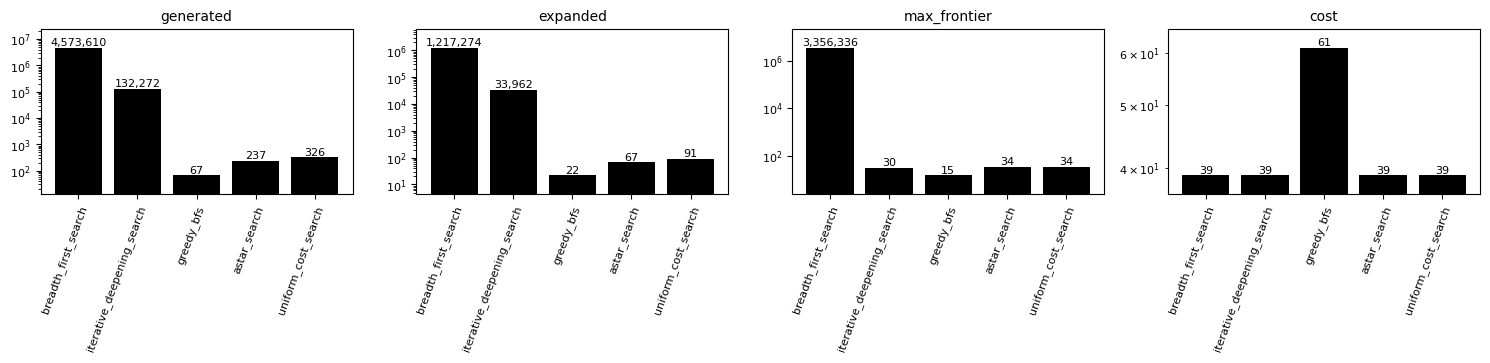

In [16]:
# Comparing the various search algos + bar plot, takes ~1-2 mins to generate plot
# number of nodes generated == result, number of nodes expanded == actions, maximum frontier size == frontier.add counter
report([breadth_first_search, iterative_deepening_search, greedy_bfs, astar_search, uniform_cost_search], [maze])

Although Greedy Best-First Search expands and generates the least nodes, including maintaining the smallest frontier size amongst the various search strategies, it does not ultimately find the most optimal path while all the remaining search algorithms do. However, because of its simple, short-term, and immediate future heuristic, it is the fastest search strategy.

The tree-search strategies (BFTS and IDS) generate and expand the most nodes, as are expected given that cycle-check only accounts for "loopy" and not redundant paths. It is also for this reason that DFTS is particularly inefficient in this scenerio, and will be further discussed in the last section of this report. 

Finally, A\*Star search is more efficient than UCS strategy, as expected since the addition of a heuristic function "biases" the search contours towards the direction of the goal node compared to just considering only the latest path cost. This leads to lesser nodes generated and expanded.

### Summary

**Greedy Best-First Search**
1. expands and generates the least nodes

2. maintains the smallest frontier size

3. does not find the optimal path to goal
 * Its simple, short-term, and immediate-future heuristic allows it to be the fastest search strategy
 
**Breadth-First Tree Search** and **Iterative Deepening Search**
1. generate and expand the most nodes
 * cycle-check only accounts for "loopy" and not redundant paths

**A\*Star Search** and **Uniform Cost Search**
1. achieves the best balance between search time, search memory requirement, and solution path cost

2. A\*Star search is more efficient than UCS with lesser nodes generated and expanded
 * addition of a heuristic function "biases" the search contours towards the direction of the goal node compared to just considering only the latest path cost

## Comparing Heuristics and their effectiveness

We have defined for our informed search strategies the simple heuristic *h_sld* of **Straight-line Distance** from each node to the goal. Let us implement a second heuristic function *h_mhd*, **Manhattan Distance**, and compare its effectiveness to *h_sld*.

greedy_MHD:
       65 nodes generated |        23 nodes expanded |        13 max frontier size| path cost   61 | Maze((8, 10), (11, 9))
       65 nodes generated |        23 nodes expanded |        13 max frontier size| path cost   61 | TOTAL

greedy_bfs:
       67 nodes generated |        23 nodes expanded |        15 max frontier size| path cost   61 | Maze((8, 10), (11, 9))
       67 nodes generated |        23 nodes expanded |        15 max frontier size| path cost   61 | TOTAL

astar_MHD:
      229 nodes generated |        66 nodes expanded |        34 max frontier size| path cost   39 | Maze((8, 10), (11, 9))
      229 nodes generated |        66 nodes expanded |        34 max frontier size| path cost   39 | TOTAL

astar_search:
      237 nodes generated |        68 nodes expanded |        34 max frontier size| path cost   39 | Maze((8, 10), (11, 9))
      237 nodes generated |        68 nodes expanded |        34 max frontier size| path cost   39 | TOTAL



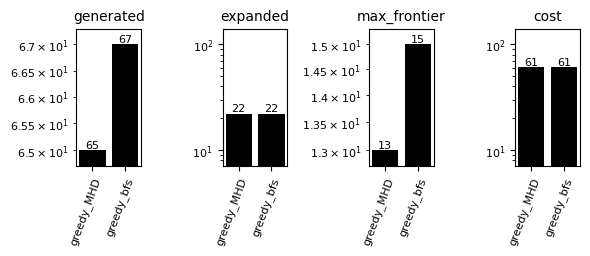

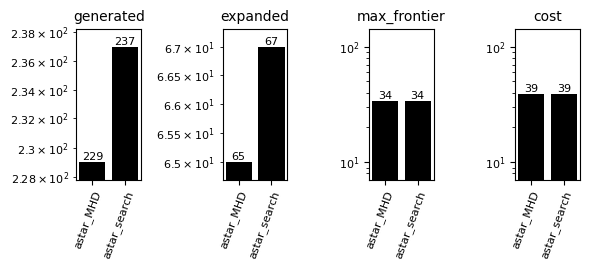

In [17]:
# %matplotlib inline
# Comparing heuristics SLD vs Manhattan Dist, for the below 2 informed search algos
def h_mhd(problem):
    """The Manhattan heuristic."""
    def wrapper(node):
        s = node.state
        return sum(abs(a - b) for (a, b) in zip(s, problem.goal))
    return wrapper

# Greedy best-first search
def greedy_MHD(problem): 
    return greedy_bfs(problem, h=h_mhd(maze))

report([greedy_MHD, greedy_bfs], [maze])

# A*
def astar_MHD(problem): 
    return astar_search(problem, h=h_mhd(maze))

report([astar_MHD, astar_search], [maze])

It is fairly obvious to see that both heuristics are consistent (and thus admissible). Therefore, we observed that solution path cost has no improvement.

**Manhattan Distance**, however, has a slight advantage over **Straight-line Distance** as a heuristic, improving the algorithm search speed with lesser nodes generated and expanded, even going so far as to reduce the maximum frontier size (and thus memory requirement) of Greedy Best-First Search algorithm. Granted, due to the small size of the problem maze, no significantly large improvements are observed.

### Summary

1. both heuristics are consistent (and thus admissible)
 * solution path cost has no observed improvements
 
 
2. **Manhattan Distance** has a slight advantage over **Straight-line Distance** as a heuristic
 * algorithm search speed improves with lesser nodes generated and expanded
 * maximum frontier size (and thus search memory requirement) may be reduced

## On spiralling down a sinkhole...

Let us turn our attention to Depth First Tree Search (DFTS) strategy for our maze problem. Because of the nature of DFTS - where the algorithm chases nodes deeper and deeper into the state space graph - it is extremely difficult for DFTS to recognise the futility of this behaviour. As a result, it never abandons its increasingly pointless exploration on the "wrong" section of the state space. We can see this behaviour with a snapshot visualisation of DFTS's path in the maze below.

_Note: Run this notebook on a JavaScript-enabled environment (e.g. browser) to see the animation live. Otherwise, snapshots of the agent's path at selected iteration steps are shown in the next section below._

In [18]:
def depth_first_tree_search(problem,step):
    """
    Searches the deepest nodes in the search tree first.
    Does not repeat infinitely in case of loops (cycle-check implemented).
    """
    frontier = LIFOQueue([Node(problem.initial)])  # stack
    counter = -1
    
    while frontier:
        node = frontier.pop()
        counter += 1

        if problem.is_goal(node.state) or counter == step:
            return node, frontier.__max__()
        elif not is_cycle(node, 400):
            for child in expand(problem, node):
                frontier.append(child)
        
    return failure, frontier.__max__()

<IPython.core.display.Javascript object>


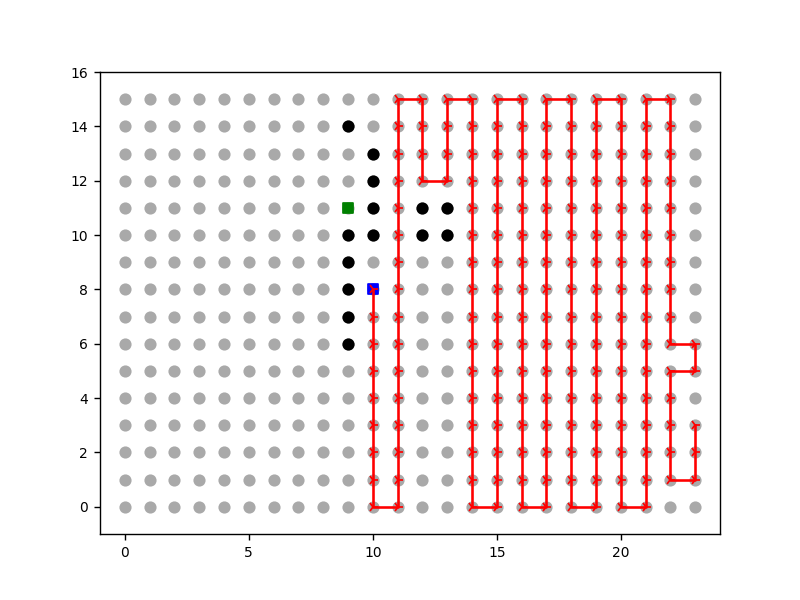

In [19]:
# Helper funcs for visualising search algos
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib notebook

def plot_maze_sol(obs, start, end, ax):
    li = [(i, j) for i in range(0,24) for j in range(0,16)]
    ax.scatter(*zip(*li), color='darkgrey')
    y, x = zip(*obs)
    ax.scatter(x, y, color='black')
    ax.scatter(end[1], end[0], marker='s',color='green')
    ax.scatter(start[1], start[0], marker='s',color='blue')
    
def plot_snapshot(i):
    node, _ = depth_first_tree_search(maze,i)
    path = path_states(node)
    k, j = zip(*path)
    return k, j

fig = plt.figure()
ax = plt.axes(xlim=(-1, 24), ylim=(-1, 16))
plot_maze_sol(walls, start, goal, ax)
data, = ax.plot([], [], marker='4', color='red')

def init():
    data.set_data([], [])
    return data,

def animate(i):
    k, j = plot_snapshot(i)
    data.set_data(j, k)
    return data,

anim = FuncAnimation(fig, animate, init_func=init, frames=10000, interval=50, blit=True)
plt.show()

<IPython.core.display.Javascript object>


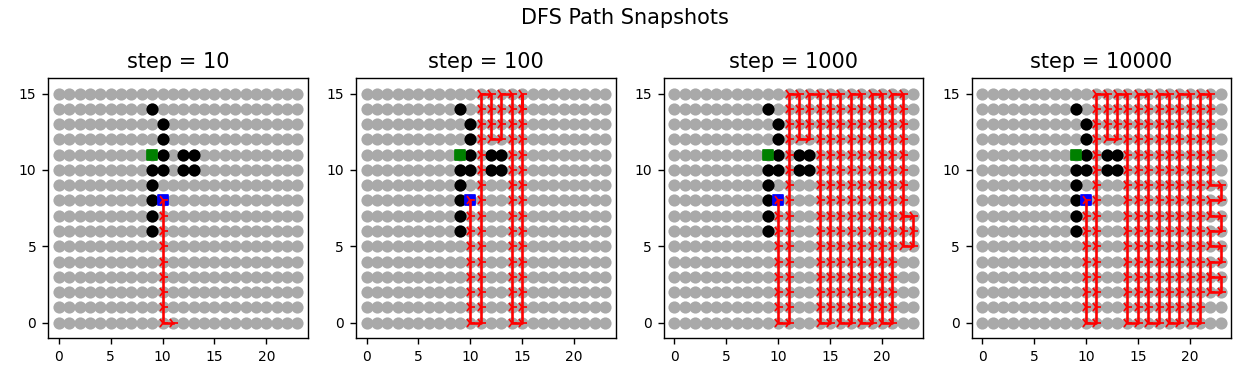

In [20]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(1, 4, figsize=(10,3))
steps = [10, 100, 1000, 10000]
for i, step in enumerate(steps):
    snapshot = axs[i]
    snapshot.set_xlim(-1, 24)
    snapshot.set_ylim(-1, 16)
    snapshot.yaxis.set_major_locator(ticker.MultipleLocator(5))
    snapshot.set_box_aspect(1)
    snapshot.set_title(label=f'step = {step}')
    
    # Plot maze data
    plot_maze_sol(walls, start, goal, snapshot)
    
    # Get path data
    k, j = plot_snapshot(step)
    snapshot.plot(j, k, marker='4', color='red')
    
plt.suptitle("DFS Path Snapshots")
plt.tight_layout()

In case you are viewing this in a non-JavaScript enabled environment, below is the exact figure produced by the plot in the cell above.

![DFTS Path Snapshots](DFTS_path_snapshot.png)

### Summary

1. Depth-First Tree Search is "not complete".
2. Cycle-check only accounts for "loopy paths" but not redundant paths.
3. If goal node is located on a neighbour branch of the root node, DFTS will first need to "back up" from the deepest node along the first branch of the root, all the while exploring neighbours which were already visited.
4. This exploration of nodes already visited (redundant paths) makes DFTS extremely inefficient.

## "Stay Calm, Do Not Panic."

In conclusion, this age-old adage holds true for any agent stuck in a maze. Blindly brute-forcing your way to the exit goal (even while systematic), only prolongs the pain and suffering of getting stuck and lost in the maze (as evident in BFTS/IDS/DFTS). Staying calm and taking stock of your environment, to implement some smart heauristics (even a simple immediate short-term future consideration strategy like Greedy-BFS) can lead to drastic improvements in solution time (albeit sometimes at the expense of route cost).

## Further Improvements for Consideration
1. Further enhance speed of A*Star Search by implementing tie breaking mechanisms for paths with same f value (http://theory.stanford.edu/~amitp/GameProgramming/Heuristics.html)

2. Weighted A*Star Search